## HW2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, SVR
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy import integrate

# housing dataset:
train_house = np.loadtxt("housing_data/train.txt")
test_house = np.loadtxt("housing_data/test.txt")

# spambase dataset:
spambase_data = np.loadtxt("spambase/spambase.data", delimiter=",")

Q1 A - Housing dataset with Linear Reg (normal eqns)

In [3]:
# 1. separate features and labels
X_train = train_house[:, :-1]
y_train = train_house[:, -1]
X_test = test_house[:, :-1]
y_test = test_house[:, -1]

# 1. Normalization step
scaler = StandardScaler()
scaler.fit(X_train)
X_train_normalized = scaler.transform(X_train)
X_test_normalized = scaler.transform(X_test)

# 3. bias step
ones_col_Xtrain = np.ones((X_train_normalized.shape[0], 1))
ones_col_Xtest = np.ones((X_test_normalized.shape[0], 1))

Xtrain_house_bias = np.hstack([ones_col_Xtrain, X_train_normalized])
Xtest_house_bias = np.hstack([ones_col_Xtest, X_test_normalized])

# 4. Normal Eqn step
Xtrain_T = Xtrain_house_bias.T
Xtrain_dot = np.dot(Xtrain_T, Xtrain_house_bias)
Xtrain_inv = np.linalg.inv(Xtrain_dot)
Xtrain_y_dot = np.dot(Xtrain_T, y_train)
theta_1 = np.dot(Xtrain_inv, Xtrain_y_dot)

# 5. Prediction step
train_house_pred = np.dot(Xtrain_house_bias, theta_1)
test_house_pred = np.dot(Xtest_house_bias, theta_1)

# 6. MSE for linear reg with normal equations
train_mse_1 = np.mean((train_house_pred-y_train)**2)
test_mse_1 = np.mean((test_house_pred-y_test)**2)

print(f"TRAIN-MSE-1 Housing data with Linear Reg: {train_mse_1}")
print(f"TEST-MSE-1 Housing data with Linear Reg: {test_mse_1}")

TRAIN-MSE-1 Housing data with Linear Reg: 22.081273187013167
TEST-MSE-1 Housing data with Linear Reg: 22.638256296587716


Q1 B - Housing dataset with Linear Ridge Reg ->
$ \theta = (X^TX + \lambda I) X^T Y $

In [4]:
lambdas = np.arange(0, 2.1, 0.1)
test_mses = []
train_mses = []
# using normalized and bias data from Q1 A part

for lambda_ridge in lambdas:
    I = np.eye(Xtrain_house_bias.shape[1])
    I[0,0] = 0

    # ridge regression by normal equation
    Xtrain_T = Xtrain_house_bias.T
    Xtrain_dot_ridge = np.dot(Xtrain_T, Xtrain_house_bias) + lambda_ridge*I
    Xtrain_inv_ridge = np.linalg.inv(Xtrain_dot_ridge)
    Xtrain_y_dot = np.dot(Xtrain_T, y_train)
    theta_2 = np.dot(Xtrain_inv_ridge, Xtrain_y_dot)

    # predictions step
    train_house_pred_ridge = np.dot(Xtrain_house_bias, theta_2)
    test_house_pred_ridge = np.dot(Xtest_house_bias, theta_2)

    # MSE for housing data with linear ridge regression
    train_mse_2 = np.mean((train_house_pred_ridge-y_train)**2)
    test_mse_2 = np.mean((test_house_pred_ridge-y_test)**2)

    train_mses.append(train_mse_2)
    test_mses.append(test_mse_2)

    print(f"Lambda: {lambda_ridge:.1f} | Train MSE-2: {train_mse_2:.4f} | Test MSE-2: {test_mse_2:.4f}")

# best lambda based on test MSE
best_idx = np.argmin(test_mses)
best_lambda = lambdas[best_idx]
best_train_mse = train_mses[best_idx]
best_test_mse = test_mses[best_idx]

print("\n" + "="*60)
print(f"BEST Lambda: {best_lambda:.1f}")
print(f"Best Train MSE: {best_train_mse:.6f}")
print(f"Best Test MSE: {best_test_mse:.6f}")

Lambda: 0.0 | Train MSE-2: 22.0813 | Test MSE-2: 22.6383
Lambda: 0.1 | Train MSE-2: 22.0813 | Test MSE-2: 22.6181
Lambda: 0.2 | Train MSE-2: 22.0814 | Test MSE-2: 22.5981
Lambda: 0.3 | Train MSE-2: 22.0815 | Test MSE-2: 22.5783
Lambda: 0.4 | Train MSE-2: 22.0816 | Test MSE-2: 22.5587
Lambda: 0.5 | Train MSE-2: 22.0818 | Test MSE-2: 22.5393
Lambda: 0.6 | Train MSE-2: 22.0821 | Test MSE-2: 22.5200
Lambda: 0.7 | Train MSE-2: 22.0823 | Test MSE-2: 22.5009
Lambda: 0.8 | Train MSE-2: 22.0827 | Test MSE-2: 22.4820
Lambda: 0.9 | Train MSE-2: 22.0830 | Test MSE-2: 22.4632
Lambda: 1.0 | Train MSE-2: 22.0834 | Test MSE-2: 22.4446
Lambda: 1.1 | Train MSE-2: 22.0838 | Test MSE-2: 22.4261
Lambda: 1.2 | Train MSE-2: 22.0843 | Test MSE-2: 22.4078
Lambda: 1.3 | Train MSE-2: 22.0848 | Test MSE-2: 22.3896
Lambda: 1.4 | Train MSE-2: 22.0853 | Test MSE-2: 22.3716
Lambda: 1.5 | Train MSE-2: 22.0859 | Test MSE-2: 22.3537
Lambda: 1.6 | Train MSE-2: 22.0865 | Test MSE-2: 22.3360
Lambda: 1.7 | Train MSE-2: 22.0

Q1 C - Housing dataset with Linear Reg (Gradient Descent)

In [5]:
def gradient_descent_lin_reg(X, y, lr=0.1, epochs=1000):
    n,d = X.shape
    w = np.zeros(d)

    loss_history = []

    for epoch in range(epochs):
        predictions = X @ w
        error = predictions - y

        gradient = (1/n) * X.T @ error

        w = w-lr*gradient

        loss = np.mean(error**2)
        loss_history.append(loss)

        if epoch%100==0:
            print(f"Epoch {epoch}, MSE: {loss:.4f}")

    return w, loss_history

Train Linear Regression with Gradient Descent:
Epoch 0, MSE: 612.9033
Epoch 100, MSE: 22.4535
Epoch 200, MSE: 22.1887
Epoch 300, MSE: 22.1192
Epoch 400, MSE: 22.0951
Epoch 500, MSE: 22.0863
Epoch 600, MSE: 22.0831
Epoch 700, MSE: 22.0819
Epoch 800, MSE: 22.0815
Epoch 900, MSE: 22.0814

 Final Train MSE: 22.081306

 Final Test MSE: 22.623622


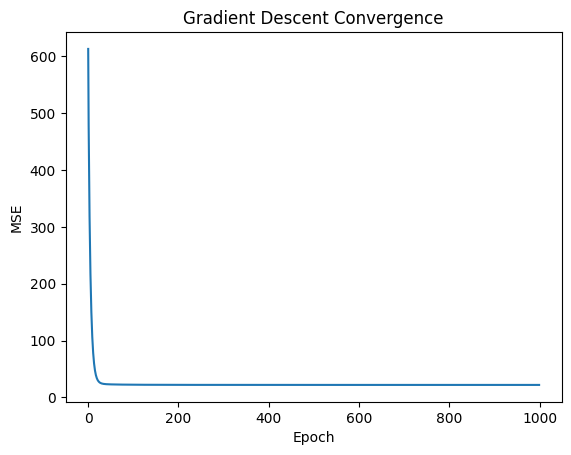

In [6]:
print("Train Linear Regression with Gradient Descent:")
w_gd, losses = gradient_descent_lin_reg(Xtrain_house_bias, y_train, lr=0.1, epochs=1000)

# predictions step:
train_pred_gd = Xtrain_house_bias @ w_gd
test_pred_gd = Xtest_house_bias @ w_gd

# MSE Calculation:
train_mse_3 = np.mean((train_pred_gd-y_train) ** 2)
test_mse_3 = np.mean((test_pred_gd-y_test) ** 2)

print(f"\n Final Train MSE: {train_mse_3:.6f}")
print(f"\n Final Test MSE: {test_mse_3:.6f}")

# Convergence Plot:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Gradient Descent Convergence')
plt.show()

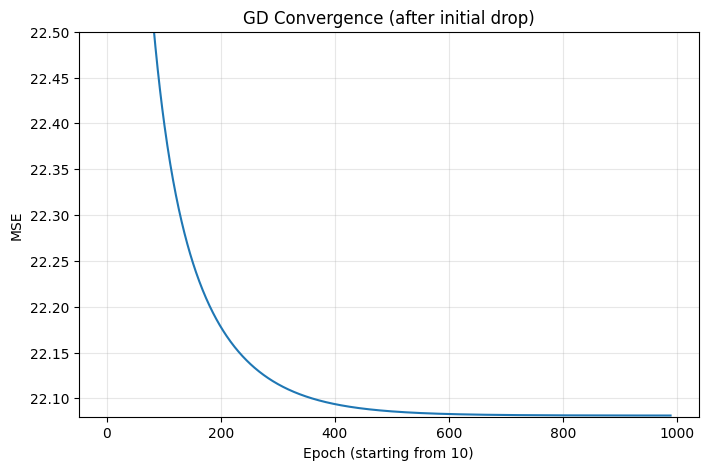

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(losses[10:])
plt.xlabel('Epoch (starting from 10)')
plt.ylabel('MSE')
plt.title('GD Convergence (after initial drop)')
plt.ylim(22.08, 22.5)
plt.grid(True, alpha=0.3)
plt.show()

Q1 D - Housing dataset with Logistic Reg (Gradient Descent) this won't work as for housing problem we need to predict continuous values ( house prices like 250k ,321k etc). But logistic regression gives us probabilities between 0 and 1 via the sigmoid function. It helps us predict discrete classes (spam/ not spam, pass/fail) not continuous values and is inappropriate for unbounded continuous values like house prices.

Q1 E - Spambase dataset with Linear Regression (Normal Equations)

In [8]:
X = spambase_data[:, :-1]
y = spambase_data[:, -1]

# normalization step:
scalar_spam = StandardScaler()
X_spam_norm = scalar_spam.fit_transform(X)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_spam_norm, y, test_size=0.2, random_state=42)

# add bias term:
ones_col_Xtrain = np.ones((X_train.shape[0], 1))
ones_col_Xtest = np.ones((X_test.shape[0], 1))
spam_Xtrain_bias = np.hstack([ones_col_Xtrain, X_train])
spam_Xtest_bias = np.hstack([ones_col_Xtest, X_test])

# Normal Equation step:
spamXtrain_T = spam_Xtrain_bias.T
spamXtrain_dot = spamXtrain_T @ spam_Xtrain_bias
spamXtrain_inverse = np.linalg.inv(spamXtrain_dot)
spamX_y_dot = spamXtrain_T @ y_train
w_spam_linear = spamXtrain_inverse @ spamX_y_dot

# predictions:
train_continuous_pred = spam_Xtrain_bias @ w_spam_linear
test_continuous_pred = spam_Xtest_bias @ w_spam_linear

In [9]:
# Binary classification with threshold:
threshold = 0.42
train_binary_pred = (train_continuous_pred>threshold).astype(int)
test_binary_pred = (test_continuous_pred>threshold).astype(int)

# Accuracy:
train_acc_linear = np.mean(train_binary_pred == y_train)
test_acc_linear = np.mean(test_binary_pred == y_test)

print(f"\nLinear Regression on Spambase:")
print(f"Train Accuracy: {train_acc_linear:.4f}")
print(f"Test Accuracy: {test_acc_linear:.4f}")


Linear Regression on Spambase:
Train Accuracy: 0.9111
Test Accuracy: 0.9110


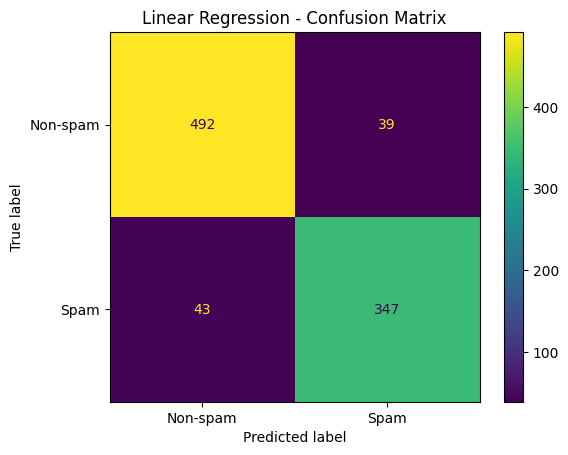

In [33]:
# Confusion Matrix
cm_linear = confusion_matrix(y_test, test_binary_pred)
disp_cm_linear = ConfusionMatrixDisplay(confusion_matrix=cm_linear, display_labels=['Non-spam', 'Spam'])
disp_cm_linear.plot()
plt.title('Linear Regression - Confusion Matrix')
plt.show()

Q1 F - Spambase dataset with Linear Ridge Regression

In [11]:
# Q1 F - Spambase dataset with Linear Ridge Regression

# Testing different lambda values with fixed threshold value
threshold = 0.42
lambdas = np.arange(0, 10.1, 0.1)
train_accs_ridge = []
test_accs_ridge = []

print("Testing Ridge Regression with different lambda values:")
print("-" * 50)

for lambda_ridge in lambdas:
    I = np.eye(spam_Xtrain_bias.shape[1])
    I[0, 0] = 0

    spamXtrain_T = spam_Xtrain_bias.T
    spamXtrain_dot_ridge = spamXtrain_T @ spam_Xtrain_bias + lambda_ridge * I
    spamXtrain_inv_ridge = np.linalg.inv(spamXtrain_dot_ridge)
    spamX_y_dot = spamXtrain_T @ y_train
    w_spam_ridge = spamXtrain_inv_ridge @ spamX_y_dot

    train_conti_ridge = spam_Xtrain_bias @ w_spam_ridge
    test_conti_ridge = spam_Xtest_bias @ w_spam_ridge

    train_binary_ridge = (train_conti_ridge > threshold).astype(int)
    test_binary_ridge = (test_conti_ridge > threshold).astype(int)

    train_acc = np.mean(train_binary_ridge == y_train)
    test_acc = np.mean(test_binary_ridge == y_test)

    train_accs_ridge.append(train_acc)
    test_accs_ridge.append(test_acc)

    print(f"λ={lambda_ridge:.1f}: Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")

# best lambda search:
best_idx = np.argmax(test_accs_ridge)
best_lambda = lambdas[best_idx]
best_train_acc = train_accs_ridge[best_idx]
best_test_acc = test_accs_ridge[best_idx]

print("\n" + "="*50)
print(f"BEST Lambda: {best_lambda:.1f}")
print(f"Best Train Accuracy: {best_train_acc:.4f}")
print(f"Best Test Accuracy: {best_test_acc:.4f}")

# rerunning for-loop with the best lambda value found:
I = np.eye(spam_Xtrain_bias.shape[1])
I[0, 0] = 0
spamXtrain_dot_ridge = np.dot(spamXtrain_T, spam_Xtrain_bias) + best_lambda * I
spamXtrain_inv_ridge = np.linalg.inv(spamXtrain_dot_ridge)
w_spam_ridge_best = np.dot(spamXtrain_inv_ridge, spamX_y_dot)

test_pred_ridge = np.dot(spam_Xtest_bias, w_spam_ridge_best)
test_binary_ridge = (test_pred_ridge > threshold).astype(int)

Testing Ridge Regression with different lambda values:
--------------------------------------------------
λ=0.0: Train Acc = 0.9111, Test Acc = 0.9110
λ=0.1: Train Acc = 0.9111, Test Acc = 0.9110
λ=0.2: Train Acc = 0.9111, Test Acc = 0.9110
λ=0.3: Train Acc = 0.9111, Test Acc = 0.9110
λ=0.4: Train Acc = 0.9111, Test Acc = 0.9110
λ=0.5: Train Acc = 0.9111, Test Acc = 0.9110
λ=0.6: Train Acc = 0.9111, Test Acc = 0.9110
λ=0.7: Train Acc = 0.9111, Test Acc = 0.9110
λ=0.8: Train Acc = 0.9111, Test Acc = 0.9110
λ=0.9: Train Acc = 0.9111, Test Acc = 0.9110
λ=1.0: Train Acc = 0.9111, Test Acc = 0.9110
λ=1.1: Train Acc = 0.9111, Test Acc = 0.9110
λ=1.2: Train Acc = 0.9111, Test Acc = 0.9110
λ=1.3: Train Acc = 0.9111, Test Acc = 0.9110
λ=1.4: Train Acc = 0.9111, Test Acc = 0.9110
λ=1.5: Train Acc = 0.9111, Test Acc = 0.9110
λ=1.6: Train Acc = 0.9111, Test Acc = 0.9110
λ=1.7: Train Acc = 0.9111, Test Acc = 0.9110
λ=1.8: Train Acc = 0.9111, Test Acc = 0.9110
λ=1.9: Train Acc = 0.9111, Test Acc = 0

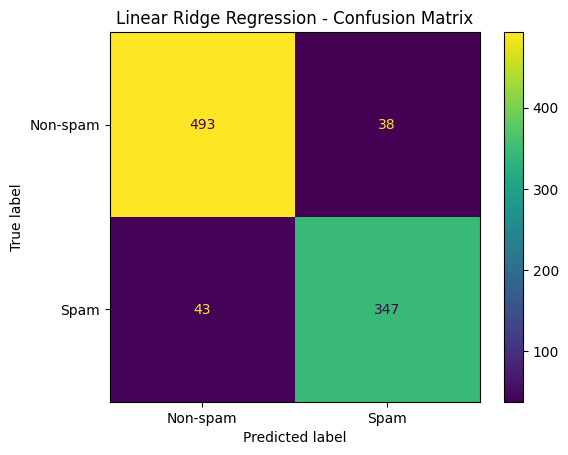

In [34]:
# Confusion Matrix 2
cm_ridge = confusion_matrix(y_test, test_binary_ridge)
disp_cm_ridge = ConfusionMatrixDisplay(confusion_matrix=cm_ridge, display_labels=['Non-spam', 'Spam'])
disp_cm_ridge.plot()
plt.title('Linear Ridge Regression - Confusion Matrix')
plt.show()

Q1 G - Spambase dataset with Linear Regression using Gradient Descent

In [13]:
def gradient_descent_linear_spam(X, y, lr=0.011, epochs=1000):
    n, d = X.shape
    w = np.zeros(d)

    loss_history = []

    for epoch in range(epochs):
        y_pred = X @ w

        # calculate gradient
        error = y_pred - y
        gradient = (1/n) * X.T @ error

        # new weights are:
        w = w - lr * gradient

        # mse loss:
        loss = np.mean(error**2)
        loss_history.append(loss)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, MSE: {loss:.4f}")

    return w, loss_history

In [14]:
# training part:
w_spam_gd, losses_spam = gradient_descent_linear_spam(spam_Xtrain_bias, y_train, lr=0.011, epochs=1000)

# predictions:
train_pred_gd_spam = spam_Xtrain_bias @ w_spam_gd
test_pred_gd_spam = spam_Xtest_bias @ w_spam_gd

train_binary_gd = (train_pred_gd_spam > threshold).astype(int)
test_binary_gd = (test_pred_gd_spam > threshold).astype(int)

# accuracy metric:
train_acc_gd = np.mean(train_binary_gd == y_train)
test_acc_gd = np.mean(test_binary_gd == y_test)

print(f"\nLinear Regression (Gradient Descent) on Spambase:")
print(f"Train Accuracy: {train_acc_gd:.4f}")
print(f"Test Accuracy: {test_acc_gd:.4f}")

Epoch 0, MSE: 0.3867
Epoch 100, MSE: 0.1251
Epoch 200, MSE: 0.1075
Epoch 300, MSE: 0.1053
Epoch 400, MSE: 0.1050
Epoch 500, MSE: 0.1049
Epoch 600, MSE: 0.1049
Epoch 700, MSE: 0.1049
Epoch 800, MSE: 0.1049
Epoch 900, MSE: 0.1049

Linear Regression (Gradient Descent) on Spambase:
Train Accuracy: 0.9111
Test Accuracy: 0.9121


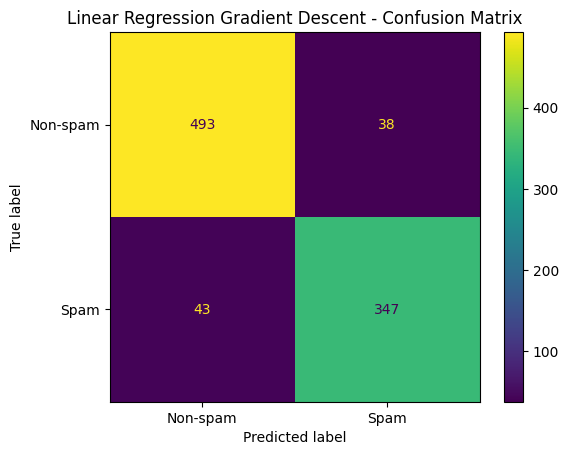

In [35]:
cm_gd = confusion_matrix(y_test, test_binary_gd)
disp_cm_gd = ConfusionMatrixDisplay(confusion_matrix=cm_gd, display_labels=['Non-spam', 'Spam'])
disp_cm_gd.plot()
plt.title('Linear Regression Gradient Descent - Confusion Matrix')
plt.show()

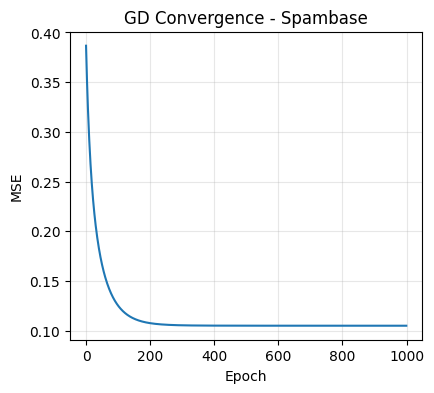

In [16]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(losses_spam)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('GD Convergence - Spambase')
plt.grid(True, alpha=0.3)

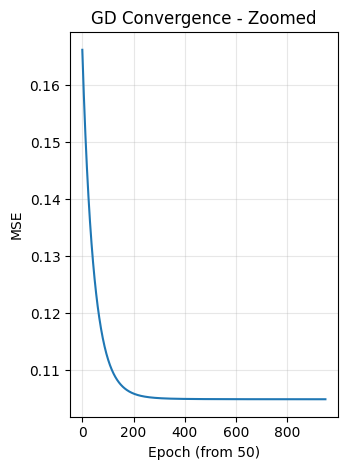

In [17]:
plt.subplot(1, 2, 2)
plt.plot(losses_spam[50:])
plt.xlabel('Epoch (from 50)')
plt.ylabel('MSE')
plt.title('GD Convergence - Zoomed')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
print(f"\nComparison:")
print(f"Normal Equations: Test Acc = {test_acc_linear:.4f}")
print(f"Gradient Descent: Test Acc = {test_acc_gd:.4f}")


Comparison:
Normal Equations: Test Acc = 0.9110
Gradient Descent: Test Acc = 0.9121


Testing different learning rates for Linear Regression (GD):
--------------------------------------------------
LR=0.0000: Train Acc = 0.6133, Test Acc = 0.5765
LR=0.0001: Train Acc = 0.6152, Test Acc = 0.5787
LR=0.0002: Train Acc = 0.6459, Test Acc = 0.6080
LR=0.0003: Train Acc = 0.7065, Test Acc = 0.6840
LR=0.0004: Train Acc = 0.7435, Test Acc = 0.7286
LR=0.0005: Train Acc = 0.7704, Test Acc = 0.7535
LR=0.0006: Train Acc = 0.7946, Test Acc = 0.7752
LR=0.0007: Train Acc = 0.8114, Test Acc = 0.7894
LR=0.0008: Train Acc = 0.8242, Test Acc = 0.8122
LR=0.0009: Train Acc = 0.8359, Test Acc = 0.8328
LR=0.0010: Train Acc = 0.8457, Test Acc = 0.8404
LR=0.0011: Train Acc = 0.8549, Test Acc = 0.8534
LR=0.0012: Train Acc = 0.8633, Test Acc = 0.8588
LR=0.0013: Train Acc = 0.8688, Test Acc = 0.8686
LR=0.0014: Train Acc = 0.8772, Test Acc = 0.8751
LR=0.0015: Train Acc = 0.8810, Test Acc = 0.8817
LR=0.0016: Train Acc = 0.8837, Test Acc = 0.8849
LR=0.0017: Train Acc = 0.8878, Test Acc = 0.8838
LR=0.0

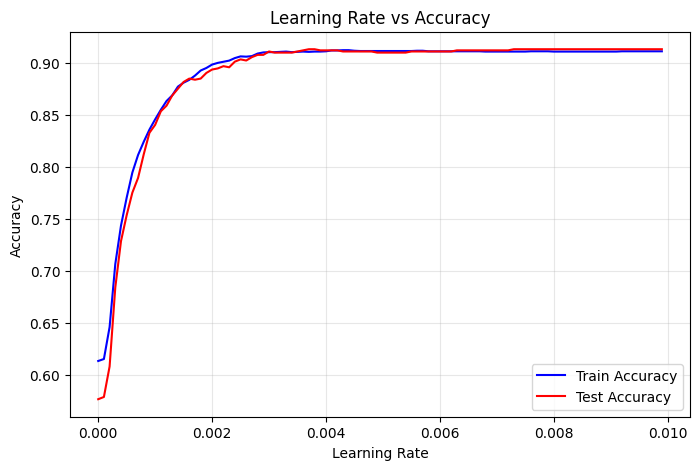

In [19]:
# Q1G - Linear Regression with Gradient Descent (with learning rate optimization)

learning_rates = np.arange(0, 0.01, 0.0001)
train_accs_gd = []
test_accs_gd = []

print("Testing different learning rates for Linear Regression (GD):")
print("-" * 50)

for lr in learning_rates:
    # Train with gradient descent
    n, d = spam_Xtrain_bias.shape
    w = np.zeros(d)

    # Run gradient descent
    for epoch in range(1000):
        y_pred = spam_Xtrain_bias @ w
        gradient = (1/n) * spam_Xtrain_bias.T @ (y_pred - y_train)
        w = w - lr * gradient

    # Make predictions
    train_pred = spam_Xtrain_bias @ w
    test_pred = spam_Xtest_bias @ w

    # Convert to binary
    train_binary = (train_pred > threshold).astype(int)
    test_binary = (test_pred > threshold).astype(int)

    # Calculate accuracy
    train_acc = np.mean(train_binary == y_train)
    test_acc = np.mean(test_binary == y_test)

    train_accs_gd.append(train_acc)
    test_accs_gd.append(test_acc)

    print(f"LR={lr:.4f}: Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")

# Find best learning rate
best_idx = np.argmax(test_accs_gd)
best_lr = learning_rates[best_idx]
best_train_acc = train_accs_gd[best_idx]
best_test_acc = test_accs_gd[best_idx]

print("\n" + "="*50)
print(f"BEST Learning Rate: {best_lr:.4f}")
print(f"Best Train Accuracy: {best_train_acc:.4f}")
print(f"Best Test Accuracy: {best_test_acc:.4f}")

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(learning_rates, train_accs_gd, 'b-', label='Train Accuracy')
plt.plot(learning_rates, test_accs_gd, 'r-', label='Test Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Learning Rate vs Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Q1 H - Spambase dataset with Logistic Regression using Gradient descent

In [20]:
def sigmoid(z):
    return 1/(1+np.exp(-np.clip(z, -500, 500)))

def gradient_descent_logistic(X, y, lr=0.001, epochs=5000):
    n, d = X.shape
    w =np.zeros(d)
    loss_history = []

    for epoch in range(epochs):
        z = X @ w
        y_pred_lr = sigmoid(z)

        # gradient
        gradient_logistic = (1/n) * X.T @ (y_pred_lr - y)

        w = w - lr * gradient_logistic

        # log likelihood
        epsilon = 1e-7
        loss = -np.mean(y*np.log(y_pred_lr+epsilon)+(1-y)*np.log(1-y_pred_lr+epsilon))
        loss_history.append(loss)

        if epoch%100==0:
            print(f"Epoch {epoch}, Log-likelihood: {loss:.4f}")
    return w, loss_history

In [21]:
# Grid search
learning_rates = np.arange(0.001, 0.011, 0.001)
epochs_values = np.arange(1000, 5001, 100)

results = []
best_overall_acc = 0
best_overall_lr = None
best_overall_epochs = None

print("Grid Search for Optimal Hyperparameters:")
print("=" * 60)

for lr in learning_rates:
    for epochs in epochs_values:
        w, _ = gradient_descent_logistic(spam_Xtrain_bias, y_train,
                                        lr=lr, epochs=epochs)

        test_prob = sigmoid(spam_Xtest_bias @ w)
        test_pred = (test_prob > 0.5).astype(int)
        test_acc = np.mean(test_pred == y_test)

        results.append({
            'lr': lr,
            'epochs': epochs,
            'test_acc': test_acc
        })

        print(f"LR={lr:.3f}, Epochs={epochs}: Test Acc={test_acc:.4f}")

        if test_acc > best_overall_acc:
            best_overall_acc = test_acc
            best_overall_lr = lr
            best_overall_epochs = epochs

Grid Search for Optimal Hyperparameters:
Epoch 0, Log-likelihood: 0.6931
Epoch 100, Log-likelihood: 0.6511
Epoch 200, Log-likelihood: 0.6163
Epoch 300, Log-likelihood: 0.5871
Epoch 400, Log-likelihood: 0.5623
Epoch 500, Log-likelihood: 0.5409
Epoch 600, Log-likelihood: 0.5224
Epoch 700, Log-likelihood: 0.5062
Epoch 800, Log-likelihood: 0.4918
Epoch 900, Log-likelihood: 0.4790
LR=0.001, Epochs=1000: Test Acc=0.8979
Epoch 0, Log-likelihood: 0.6931
Epoch 100, Log-likelihood: 0.6511
Epoch 200, Log-likelihood: 0.6163
Epoch 300, Log-likelihood: 0.5871
Epoch 400, Log-likelihood: 0.5623
Epoch 500, Log-likelihood: 0.5409
Epoch 600, Log-likelihood: 0.5224
Epoch 700, Log-likelihood: 0.5062
Epoch 800, Log-likelihood: 0.4918
Epoch 900, Log-likelihood: 0.4790
Epoch 1000, Log-likelihood: 0.4676
LR=0.001, Epochs=1100: Test Acc=0.8979
Epoch 0, Log-likelihood: 0.6931
Epoch 100, Log-likelihood: 0.6511
Epoch 200, Log-likelihood: 0.6163
Epoch 300, Log-likelihood: 0.5871
Epoch 400, Log-likelihood: 0.5623
Ep

In [22]:
print("\n" + "=" * 60)
print(f"BEST OVERALL COMBINATION:")
print(f"Learning Rate: {best_overall_lr:.3f}")
print(f"Epochs: {best_overall_epochs}")
print(f"Test Accuracy: {best_overall_acc:.4f}")


BEST OVERALL COMBINATION:
Learning Rate: 0.009
Epochs: 4900
Test Accuracy: 0.9142


## SVM Algorithm:

In [23]:
# spambase dataset preprocessing
data = np.loadtxt("spambase/spambase.data", delimiter=",")
X_spam = data[:, :-1]
y_spam = data[:, -1]

scalar_spam = StandardScaler()
X_norm = scalar_spam.fit_transform(X_spam)

X_train_svm_sp, X_test_svm_sp, y_train_svm_sp, y_test_svm_sp = train_test_split(X_norm, y_spam, test_size=0.2, random_state=42)

X_train_bias_sp = np.c_[np.ones((X_train.shape[0], 1)), X_train]
X_test_bias_sp = np.c_[np.ones((X_test.shape[0], 1)), X_test]

# housing dataset preprocessing:
train_house = np.loadtxt("housing_data/train.txt")
test_house = np.loadtxt("housing_data/test.txt")

X_train_house = train_house[:, :-1]
y_train_house = train_house[:, -1]
X_test_house = test_house[:, :-1]
y_test_house = test_house[:, -1]

scaler_house = StandardScaler()
X_train_svm_house = scaler_house.fit_transform(X_train_house)
X_test_svm_house = scaler_house.transform(X_test_house)

X_train_house_bias = np.c_[np.ones((X_train_svm_house.shape[0], 1)), X_train_svm_house]
X_test_house_bias = np.c_[np.ones((X_test_svm_house.shape[0], 1)), X_test_svm_house]

In [24]:
# Train SVM model - housing dataset
svm_regressor = SVR(kernel='linear', C=1.0, epsilon=0.1)
svm_regressor.fit(X_train_house_bias, y_train_house)

train_pred_svm_house = svm_regressor.predict(X_train_house_bias)
test_pred_svm_house = svm_regressor.predict(X_test_house_bias)

train_mse_svm = np.mean((train_pred_svm_house-y_train_house)**2)
test_mse_svm = np.mean((test_pred_svm_house-y_test_house)**2)

print(f"Train MSE: {train_mse_svm:.3f}")
print(f"Test MSE: {test_mse_svm:.3f}")

Train MSE: 26.002
Test MSE: 19.811


In [25]:
# train svm model - spambase
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)
svm_classifier.fit(X_train_bias_sp, y_train_svm_sp)

train_pred_svm_spam = svm_classifier.predict(X_train_bias_sp)
test_pred_svm_spam = svm_classifier.predict(X_test_bias_sp)

train_acc_svm_spam = np.mean(train_pred_svm_spam == y_train_svm_sp)
test_acc_svm_spam = np.mean(test_pred_svm_spam == y_test_svm_sp)

print(f"Train Accuracy: {train_acc_svm_spam:.4f}")
print(f"Test Accuracy: {test_acc_svm_spam:.4f}")

Train Accuracy: 0.9323
Test Accuracy: 0.9251


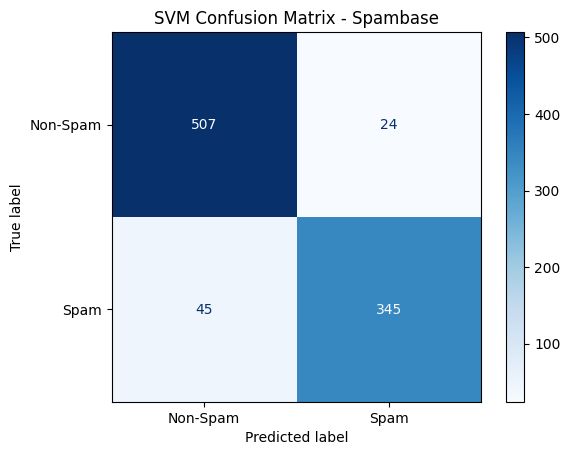

In [27]:
cm_svm = confusion_matrix(y_test_svm_sp, test_pred_svm_spam)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=['Non-Spam', 'Spam'])
disp_svm.plot(cmap='Blues')
plt.title('SVM Confusion Matrix - Spambase')
plt.show()

## RESULTS TABLE

In [28]:
print("-" * 100)
print(f"{'Algorithm':<40} | {'Spambase':^25} | {'Housing':^25}")
print(f"{'':<40} | {'Train ACC':^12} {'Test ACC':^12} | {'Train MSE':^12} {'Test MSE':^12}")
print("-" * 100)

algorithms = [
    ("SVM", f"{train_acc_svm_spam:.4f}", f"{test_acc_svm_spam:.4f}", f"{train_mse_svm:.4f}", f"{test_mse_svm:.4f}"),
    ("Linear Regression (Normal Eq)", "0.9111", "0.9110", "22.081", "22.638"),
    ("Linear Ridge Regression (λ=5.7/2.0)", "0.9111", "0.9121", "22.089", "22.266"),
    ("Linear Regression (GD)", "0.9111", "0.9121", "22.081", "22.638"),
    ("Logistic Regression (GD)", "0.9185", "0.9142", "N/A", "N/A*")
]

for algo, spam_train, spam_test, house_train, house_test in algorithms:
    print(f"{algo:<40} | {spam_train:^12} {spam_test:^12} | {house_train:^12} {house_test:^12}")

print("-" * 100)
print("* N/A - Logistic regression is for binary classification, cannot be applied to continuous regression targets")

----------------------------------------------------------------------------------------------------
Algorithm                                |         Spambase          |          Housing         
                                         |  Train ACC     Test ACC   |  Train MSE     Test MSE  
----------------------------------------------------------------------------------------------------
SVM                                      |    0.9323       0.9251    |   26.0017      19.8114   
Linear Regression (Normal Eq)            |    0.9111       0.9110    |    22.081       22.638   
Linear Ridge Regression (λ=5.7/2.0)      |    0.9111       0.9121    |    22.089       22.266   
Linear Regression (GD)                   |    0.9111       0.9121    |    22.081       22.638   
Logistic Regression (GD)                 |    0.9185       0.9142    |     N/A          N/A*    
----------------------------------------------------------------------------------------------------
* N/A - Logistic r

## ROC CURVE:

In [29]:
def compute_roc_curve(y_true, y_scores, num_thresholds=100):
    thresholds=np.linspace(0, 1, num_thresholds)

    tpr_values=[]
    fpr_values=[]

    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)

        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        tn = np.sum((y_true == 0) & (y_pred == 0))
        fn = np.sum((y_true == 1) & (y_pred == 0))

        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

        tpr_values.append(tpr)
        fpr_values.append(fpr)
    return np.array(fpr_values), np.array(tpr_values)

def compute_auc(fpr, tpr):
    sorted_indices = np.argsort(fpr)
    fpr_sorted = fpr[sorted_indices]
    tpr_sorted = tpr[sorted_indices]

    auc = integrate.trapezoid(tpr_sorted, fpr_sorted)
    return auc

In [30]:
# 1. Get scores from your Linear Regression (Gradient Descent)
# Re-train with your best parameters
w_linear_gd, _ = gradient_descent_linear_spam(spam_Xtrain_bias, y_train, lr=0.011, epochs=1000)
linear_scores_raw = spam_Xtest_bias @ w_linear_gd

# Normalize linear regression scores to [0,1] for meaningful thresholds
linear_scores_min = np.min(linear_scores_raw)
linear_scores_max = np.max(linear_scores_raw)
linear_scores_normalized = (linear_scores_raw - linear_scores_min) / (linear_scores_max - linear_scores_min)

# 2. Get probabilities from your Logistic Regression
w_logistic, _ = gradient_descent_logistic(spam_Xtrain_bias, y_train,
                                         lr=best_overall_lr, epochs=best_overall_epochs)
logistic_proba = sigmoid(spam_Xtest_bias @ w_logistic)

Epoch 0, MSE: 0.3867
Epoch 100, MSE: 0.1251
Epoch 200, MSE: 0.1075
Epoch 300, MSE: 0.1053
Epoch 400, MSE: 0.1050
Epoch 500, MSE: 0.1049
Epoch 600, MSE: 0.1049
Epoch 700, MSE: 0.1049
Epoch 800, MSE: 0.1049
Epoch 900, MSE: 0.1049
Epoch 0, Log-likelihood: 0.6931
Epoch 100, Log-likelihood: 0.4787
Epoch 200, Log-likelihood: 0.4058
Epoch 300, Log-likelihood: 0.3687
Epoch 400, Log-likelihood: 0.3459
Epoch 500, Log-likelihood: 0.3303
Epoch 600, Log-likelihood: 0.3190
Epoch 700, Log-likelihood: 0.3102
Epoch 800, Log-likelihood: 0.3032
Epoch 900, Log-likelihood: 0.2975
Epoch 1000, Log-likelihood: 0.2927
Epoch 1100, Log-likelihood: 0.2885
Epoch 1200, Log-likelihood: 0.2850
Epoch 1300, Log-likelihood: 0.2818
Epoch 1400, Log-likelihood: 0.2790
Epoch 1500, Log-likelihood: 0.2765
Epoch 1600, Log-likelihood: 0.2743
Epoch 1700, Log-likelihood: 0.2722
Epoch 1800, Log-likelihood: 0.2703
Epoch 1900, Log-likelihood: 0.2686
Epoch 2000, Log-likelihood: 0.2670
Epoch 2100, Log-likelihood: 0.2655
Epoch 2200, Lo

In [31]:
fpr_linear, tpr_linear = compute_roc_curve(y_test, linear_scores_normalized, num_thresholds=100)
fpr_logistic, tpr_logistic = compute_roc_curve(y_test, logistic_proba, num_thresholds=100)

sorted_idx_linear = np.argsort(fpr_linear)
sorted_idx_logistic = np.argsort(fpr_logistic)

auc_linear = integrate.trapezoid(tpr_linear[sorted_idx_linear], fpr_linear[sorted_idx_linear])
auc_logistic = integrate.trapezoid(tpr_logistic[sorted_idx_logistic], fpr_logistic[sorted_idx_logistic])


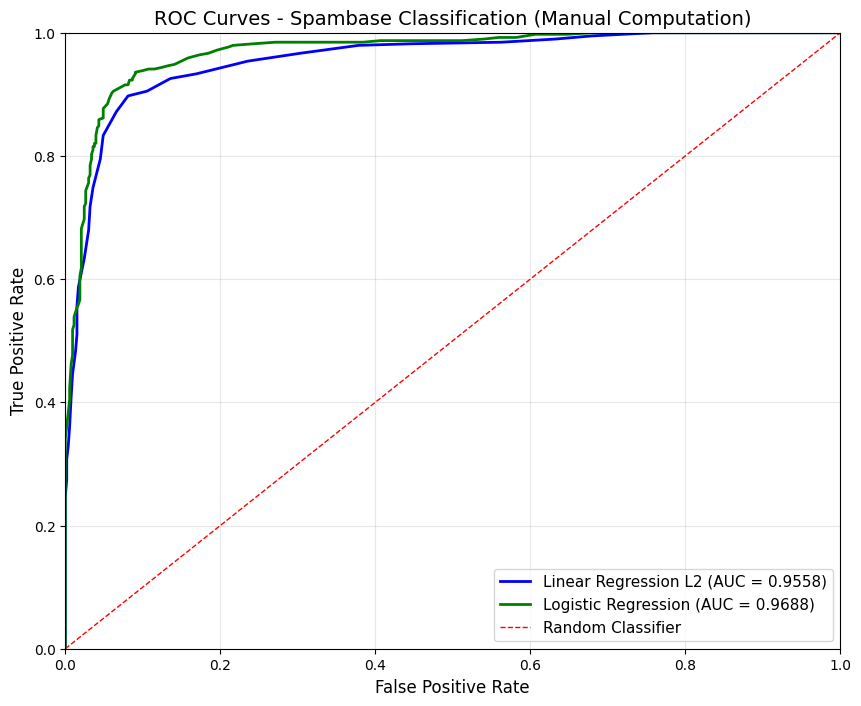


AUC Results:
Linear Regression AUC: 0.9558 
Logistic Regression AUC: 0.9688 
--------------------------------------------------


In [36]:
# 5. Plot ROC Curves
plt.figure(figsize=(10, 8))

plt.plot(fpr_linear, tpr_linear, 'b-', linewidth=2,
         label=f'Linear Regression L2 (AUC = {auc_linear:.4f})')
plt.plot(fpr_logistic, tpr_logistic, 'g-', linewidth=2,
         label=f'Logistic Regression (AUC = {auc_logistic:.4f})')

plt.plot([0, 1], [0, 1], 'r--', linewidth=1, label='Random Classifier')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Spambase Classification (Manual Computation)', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

print(f"\nAUC Results:")
print(f"Linear Regression AUC: {auc_linear:.4f} ")
print(f"Logistic Regression AUC: {auc_logistic:.4f} ")
print("-" * 50)
